In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from itertools import islice
from torch.utils.data import DataLoader

from tenebris.domain.methods.grad_cam import GradCAMMethod
from tenebris.domain.methods.lrp import LRPEpsilonMethod
from tenebris.domain.methods.occlusion import OcclusionMethod
from tenebris.domain.metrics.computation_time import ComputationTimeMetric
from tenebris.domain.metrics.deletion_check import DeletionCheck
from tenebris.domain.metrics.preservation_check import PreservationCheck
from tenebris.benchmark import BenchmarkService

In [2]:
# Dataset

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST('data/', train=True, transform=transform, download=False)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
test_dataset = torchvision.datasets.MNIST('data/', train=False, transform=transform, download=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

In [3]:
# Model

class MyConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 2, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(2, 6, 5)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(96, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = x.view(-1, 96)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

model = MyConvNet()

model.load_state_dict(torch.load("mnist-classifier.pth"))

<All keys matched successfully>

In [4]:
# Methods
grad_cam = GradCAMMethod(model, layer_getter = lambda m: m.conv2)
lrp_epsilon = LRPEpsilonMethod(model)
occlusion = OcclusionMethod(model, (1, 2, 2), 2, 0)

methods = [grad_cam, lrp_epsilon, occlusion]

In [5]:
# Metrics

# computation_time_metric = ComputationTimeMetric()
deletion_check = DeletionCheck()
preservation_check = PreservationCheck()

# metrics = [computation_time_metric, deletion_check, preservation_check]
metrics = [deletion_check, preservation_check]


In [ ]:
# Benchmark

benchmark = BenchmarkService(metrics=metrics, methods=methods)
benchmark.run(list(islice(test_dataloader, 1000)))


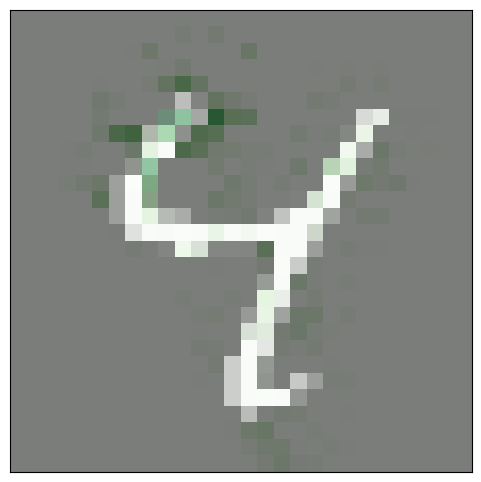

torch.Size([1, 1, 28, 28])


In [8]:
from captum.attr._utils.visualization import visualize_image_attr

image, label = data[6]
attribution = lrp_epsilon.attribute(image, label)

img = np.transpose(image[0].detach().numpy(), (1, 2, 0))
attr = np.transpose(attribution[0].detach().numpy(), (1, 2, 0))

_ = visualize_image_attr(attr, original_image=img, method="blended_heat_map", sign="positive")

print(image.size())

In [10]:
from tenebris.domain.tensors.functions import positive_attribution_mask

image, label = data[6]
attribution = occlusion.attribute(image, label)
binary_attribution = positive_attribution_mask(attribution)

attributions_only_image = image * binary_attribution

print(f"Image size: {image.size()}")
print(f"Attribution size: {attribution.size()}")
print(f"Binary attribution size: {binary_attribution.size()}")

out = model(image)
attribution_only_out = model(attributions_only_image)

print(torch.max(out, dim=1), torch.max(attribution_only_out, dim=1))

Image size: torch.Size([1, 1, 28, 28])
Attribution size: torch.Size([1, 1, 28, 28])
Binary attribution size: torch.Size([1, 1, 28, 28])
torch.return_types.max(
values=tensor([0.9992], grad_fn=<MaxBackward0>),
indices=tensor([4])) torch.return_types.max(
values=tensor([0.9997], grad_fn=<MaxBackward0>),
indices=tensor([4]))


In [11]:
benchmark.results()

{'ComputationTimeMetric': defaultdict(list,
             {'GuidedGradCam': [0.022142887115478516,
               0.001081228256225586,
               0.0009121894836425781],
              'LRP with Epsilon rule': [0.0022919178009033203,
               0.0013971328735351562,
               0.0012001991271972656],
              'Occlusion': [0.06215500831604004,
               0.05653786659240723,
               0.10953307151794434]}),
 'DeletionCheck': defaultdict(list,
             {'GuidedGradCam': [True, True, True],
              'LRP with Epsilon rule': [True, True, False],
              'Occlusion': [True, False, True]}),
 'PreservationCheck': defaultdict(list,
             {'GuidedGradCam': [False, False, False],
              'LRP with Epsilon rule': [True, True, False],
              'Occlusion': [True, True, True]})}

In [12]:
benchmark.reduce_results()

{'ComputationTimeMetric': {'GuidedGradCam': 0.008045434951782227,
  'LRP with Epsilon rule': 0.0016297499338785808,
  'Occlusion': 0.07607531547546387},
 'DeletionCheck': {'GuidedGradCam': 1.0,
  'LRP with Epsilon rule': 0.6666666666666666,
  'Occlusion': 0.6666666666666666},
 'PreservationCheck': {'GuidedGradCam': 0.0,
  'LRP with Epsilon rule': 0.6666666666666666,
  'Occlusion': 1.0}}